In [ ]:
# develop-exponential-decay-translation.ipynb
#
# Bryan Daniels
# 2024/1/25
#
# Trying to get closer to a "Laplace transform of delta functions" by
# specifying that individual neuron states decay exponentially over time
#
# Working from results in develop-self-sustained-translation-operator.ipynb

In [4]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

from laplace_network import laplace_network,find_edge_location,interaction_matrix_from_kernel

In [7]:
def edge_Jmat_with_shift(edge_shift,t_0,n_0,Npopulation,J):
    kernel = [desiredBumpRates(Npopulation-10-n,t_0,n_0=(Npopulation-10)/2-edge_shift) for n in range(Npopulation-10+1)]
    return J*interaction_matrix_from_kernel(kernel,Npopulation)

In [8]:
def edge_one_step_velocity(edge_Jmat,sigma_edge,t_0,n_0,Npopulation,J,delta_z):
    """
    Change in position of the edge after going once through the synaptic nonlinearity and given interaction matrix.
    """
    edge_state = J*(2*desiredEdgeRates(np.arange(0,Npopulation),t_0,delta_z=delta_z,n_0=n_0)-1)
    edge_synaptic_out = net.nonlinearity(edge_state/sigma_edge)
    corresponding_steady_state = np.dot(edge_Jmat,edge_synaptic_out)
    steady_state_n_bar = np.sort(abs(find_edge_location(corresponding_steady_state)))[0]
    return steady_state_n_bar - n_0

In [9]:
def find_zero_velocity_edge_shift(sigma_edge,t_0,n_0,Npopulation,J,delta_z):
    """
    Find interaction matrix edge shift that gives zero velocity under the dynamics with given sigma_edge.

    Note: sigma_edge = 0 should correspond to zero velocity with edge shift = 0. 
    """
    vel_sq = lambda edge_shift: edge_one_step_velocity(edge_Jmat_with_shift(edge_shift,t_0,n_0,Npopulation,J),
                                                       sigma_edge,t_0,n_0,Npopulation,J,delta_z)**2
    result = scipy.optimize.minimize_scalar(vel_sq) #,bracket=(-1,0,1))
    assert(result['fun'] < 1e-10) # make sure we were successful
    return result['x']

In [10]:
def zero_velocity_edge_Jmat(sigma_edge,t_0,n_0,Npopulation,J,delta_z):
    """
    Return edge_Jmat interaction matrix that gives zero velocity under the dynamics with given sigma_edge.
    """
    edge_shift = find_zero_velocity_edge_shift(sigma_edge,t_0,n_0,Npopulation,J,delta_z)
    return edge_Jmat_with_shift(edge_shift,t_0,n_0,Npopulation,J)

In [11]:
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #1./8. #1./4 #1./4. #0.5 #1 
n_0 = 30 #15 #15 # 25 (25 used for 231117 plots)
t_0 = 10. #5 #1. #10. #10. #1. (1. used for 231117 plots) #0.1 #0.5

fiddle_offset = 0 # (should be 0?)
fudge_factor = 1  # (should be 1?)

# define the shapes of edges and bumps we want in order to get exponential decay

def desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0,t_0=t_0):
    return np.exp( -(t/t_0)*np.exp(-delta_z*(n-n_0)+np.log(np.log(2))) )

# 2024/2/2 TO DO: Should this have another factor of t_0 somewhere?
def desiredBumpRates(n,t,delta_z=delta_z,n_0=n_0):
    return t*desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0)*delta_z/np.exp(delta_z*(n-n_0))

In [66]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 100 #50 # number of units in each population
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n 
J_bump_edge_max = 10 #0.2 #10 # to avoid instability
J_bump_edge_scale_factor = 0.65 # 0.65 fit by eye for sigma_edge=0.5 #1. #0.4 # *** 1 #2 #0.1 #0.5 #0.9 (0.9 used for 231117 plots)
J_bump_edge = [ -J_bump_edge_scale_factor*min(1./t_0*1./delta_z*np.exp(-delta_z*fudge_factor*(n-n_0)),
                                              J_bump_edge_max) for n in range(Npopulation) ]
nonlinearity = np.tanh #lambda x: 2*np.heaviside(x,0.5) - 1 # np.tanh
# 2024/1/26 set sigma to 1 for all synapses except edge->edge
sigma_edge = 0.25 #0.25 #0.5 #0.25 #0.75 #0.25 #0.5
sigma_default = np.ones([Npopulation,Npopulation])
sigma = np.block([[sigma_edge*sigma_default, sigma_default],
                  [           sigma_default, sigma_default]])

net = laplace_network(Npopulation,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      #kernel_width=kernel_width,
                      nonlinearity=nonlinearity,
                      sigma=sigma)

# 2024/1/23 try replacing edge interaction kernel to give the desired steady state given the 
# step-function nonlinearity
# 2024/2/6 also add a shift to fix the bias coming from nonzero sigma

#nonzero_sigma_kernel = [desiredBumpRates(Npopulation-10-n,t_0,n_0=(Npopulation-10)/2-3.*edge_shift) for n in range(Npopulation-10+1)]
#net.edge_Jmat = J*interaction_matrix_from_kernel(nonzero_sigma_kernel,Npopulation)
net.edge_Jmat = zero_velocity_edge_Jmat(sigma_edge,t_0,n_0,Npopulation,J,delta_z)

# # 2024/1/26 also design edge->bump interactions (see below)
# bump_kernel = np.array([desiredBumpRates(30-n,1,n_0=14) for n in range(32)]) # n_0=13?
# deriv_bump_kernel = bump_kernel[:-1] - bump_kernel[1:]
# net.edge_bump_Jmat = delta_z**4*interaction_matrix_from_kernel(deriv_bump_kernel,Npopulation,normed=True)

net.Jmat = np.block([[net.edge_Jmat, net.bump_edge_Jmat],
                     [net.edge_bump_Jmat, net.bump_Jmat]])
net.Jmat_no_feedback = np.block([[net.edge_Jmat, np.zeros((Npopulation,Npopulation))],
                                 [net.edge_bump_Jmat, net.bump_Jmat]])

In [67]:
find_zero_velocity_edge_shift(sigma_edge,t_0,n_0,Npopulation,J,delta_z)

0.03041184416961996

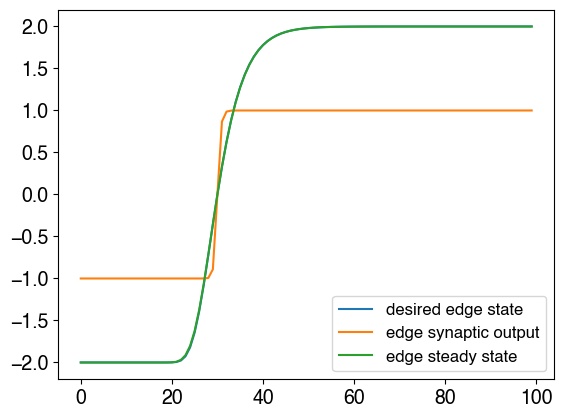

In [68]:
# 2024/1/26 check that edge_Jmat gives the desired edge output when given step function input
edge_state = net.J*(2*desiredEdgeRates(np.arange(0,Npopulation),t_0,delta_z=delta_z,n_0=n_0)-1)
edge_synaptic_out = net.nonlinearity(edge_state/sigma_edge)
corresponding_steady_state = np.dot(net.edge_Jmat,edge_synaptic_out)
plt.plot(edge_state,label='desired edge state')
plt.plot(edge_synaptic_out,label='edge synaptic output')
plt.plot(corresponding_steady_state,label='edge steady state')
plt.legend()

In [69]:
# check that the edge steady state has the desired n_bar
np.sort(abs(find_edge_location(corresponding_steady_state)))[0]-30

-1.3571366253017914e-12

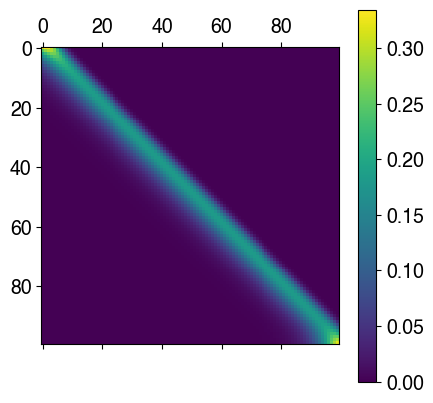

In [70]:
# "desired bump rates" interaction matrix
plt.matshow(net.edge_Jmat)
plt.colorbar()

In [71]:
# run simulation

# noise_var = 1e-6 (1e-6 used for more recent plots) #1e-4 (1e-4 used for 231117 plots) # 0.1
noise_var = 1e-6 #0. # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0 + 2**(i_final-1)
delta_t = 0.01 #0.001 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = t_0 
initial_guess_edge = net.J*(2*desiredEdgeRates(np.arange(0,Npopulation),edge_t,delta_z=delta_z,n_0=n_0-fiddle_offset)-1)
#initial_guess_edge += net.inputExt[:Npopulation]
edge_state = net.find_edge_state(n_0,
                                 initial_guess_edge=initial_guess_edge,
                                 method='translate')

# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_0,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_0

(-4.95, 103.95, -10.0, 10.0)

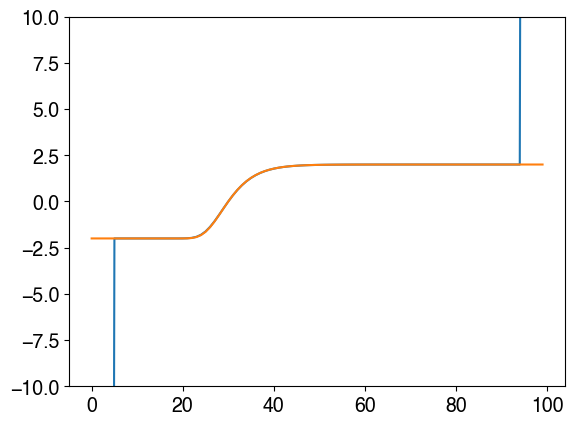

In [72]:
plt.plot(edge_state[:Npopulation])
plt.plot(initial_guess_edge)
plt.axis(ymin=-10,ymax=+10)

In [73]:
def nice_neuron_xlabels(Npopulation):
    labels=['' for i in range(Npopulation)]
    labeled_n = [0,int(Npopulation/2),Npopulation-1]
    for n in labeled_n:
        labels[n] = n
    plt.xticks(ticks=range(Npopulation),labels=labels)
    defaultFigure.makePretty()

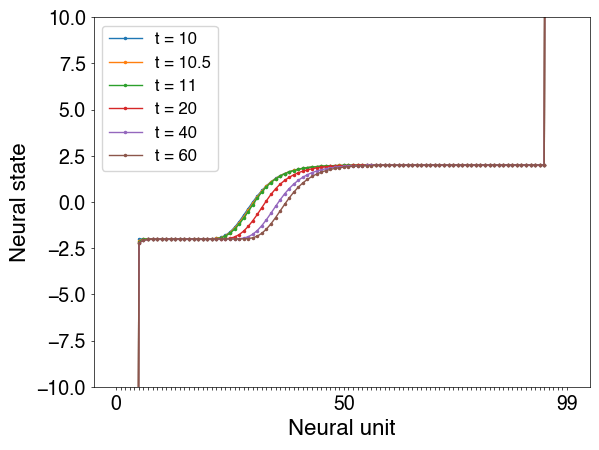

In [74]:
# 2024/1/23 debugging step-function simulation
for t in [10,10.5,11,20,40,60]:
    plt.plot(states.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.axis(ymin=-10,ymax=+10)
plt.legend()
plt.xlabel('Neural unit')
plt.ylabel('Neural state')
nice_neuron_xlabels(Npopulation)

Text(0, 0.5, 'Neural state')

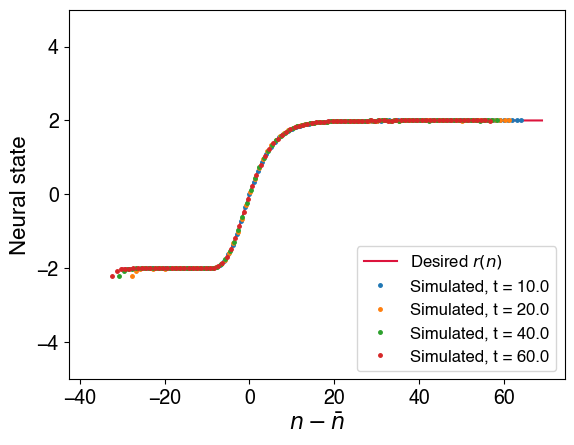

In [75]:
# compare simulated shape of edge to desired shape

nList = np.arange(0,Npopulation)
t = 20 #1 #20
desired_edge_shape = net.J*(2*desiredEdgeRates(nList,edge_t,delta_z=delta_z,n_0=n_0)-1)
desired_edge_offset = find_edge_location(desired_edge_shape)[0]
plt.plot(nList-desired_edge_offset,desired_edge_shape,
         label='Desired $r(n)$',
         color='crimson')

for t in [t_0,t_0*2,t_0*4,t_0*6]:
    edge_offset = np.sort(abs(find_edge_location(states.loc[t])))[0]
    plt.plot(nList - edge_offset,
             states.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="Simulated, t = {}".format(t),lw=1,ms=5)
plt.axis(ymin=-5,ymax=+5)
plt.legend()
plt.xlabel('$n - \\bar n$')
plt.ylabel('Neural state')
#nice_neuron_xlabels(Npopulation)

# plt.plot(nList,desiredBumpRates(nList,t,delta_z=1/2),
#          label='Desired $dr(n)/dn$',
#          color='crimson',ls='--')

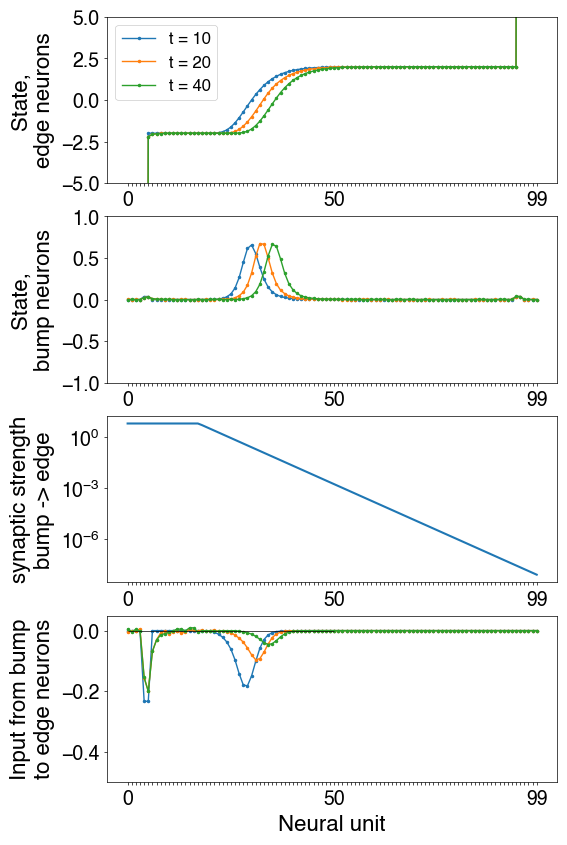

In [79]:
plt.figure(figsize=(6,9))
minInput,maxInput = 0,4
minState,maxState = -5,5 #0,1 #-1,1
times = [t_0,t_0*2,t_0*4]

# firing rate plot, edge neurons
plt.subplot(4,1,1)
for t in times:
    plt.plot(states.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(int(t)),lw=1,ms=3)
#plt.hlines(0,0,50,color='k',lw=0.5)
#plt.xlabel('Neural unit')
plt.ylabel('State,\nedge neurons')
nice_neuron_xlabels(net.Npopulation)
leg = plt.legend(framealpha=1)
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minState,ymax=maxState)

# firing rate plot, bump neurons
plt.subplot(4,1,2)
for t in times:
    plt.plot(states.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
#plt.hlines(0,0,50,color='k',lw=0.5)   
#plt.xlabel('Neural unit')
plt.ylabel('State,\nbump neurons')
nice_neuron_xlabels(net.Npopulation)
#leg = plt.legend(framealpha=1)
defaultFigure.makePretty()
#plt.axis(ymin=minState,ymax=maxState)
plt.axis(ymin=-1,ymax=+1)

# interaction strength from bump to edge neurons
plt.subplot(4,1,3)
plt.plot(-np.array(J_bump_edge))
plt.ylabel('synaptic strength\nbump -> edge')
#plt.xlabel('Neural unit')
plt.yscale('log')
nice_neuron_xlabels(net.Npopulation)

# input from bump neurons to edge neurons
plt.subplot(4,1,4)
for t in times:
    if np.shape(net.sigma) == (net.Ntotal,net.Ntotal):
        #activities = [ np.tanh(np.tile(np.array(states.loc[i]),(net.Ntotal,1))/net.sigma) for i in states.index ]
        #bumpActivities = np.array(activities)[Npopulation:2*Npopulation-1]
        #print("Haven't figured out plotting bump->edge neuron input for non-constant sigma yet")
        activities_t = np.tanh(np.tile(states.loc[t],(net.Ntotal,1))/net.sigma) # (NtotalxNtotal)
        bump_to_edge_activities = activities_t[:Npopulation,Npopulation:2*Npopulation] # (NpopulationxNpopulation)
        bump_to_edge_input = np.sum(net.bump_edge_Jmat*np.array(bump_to_edge_activities),axis=1) # (N)
        bump_to_edge_input = pd.Series(bump_to_edge_input,index=states.columns[:Npopulation])
    else:
        activities = np.tanh(states/net.sigma)
        
        bumpActivities = activities.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)]
        bump_to_edge_input = np.dot(bumpActivities,net.bump_edge_Jmat)
    plt.plot(bump_to_edge_input,'.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
plt.xlabel('Neural unit')
plt.ylabel('Input from bump\nto edge neurons')
nice_neuron_xlabels(net.Npopulation)
plt.axis(ymin=-0.5,ymax=+0.05)


plt.subplots_adjust(bottom=0.1,top=0.95,left=0.2,right=0.95)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')

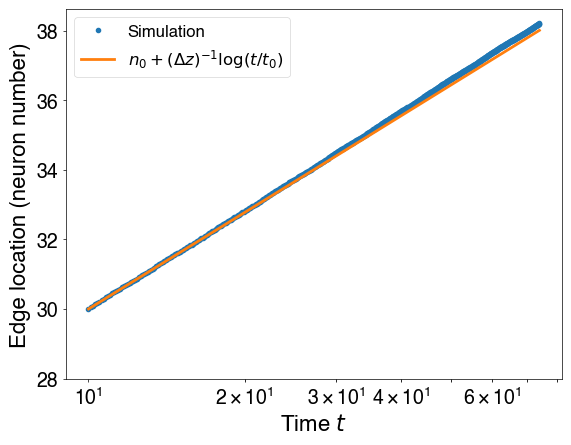

In [77]:
# plot edge location versus time
skip = 10
plt.plot(states.index[::skip],[np.sort(abs(find_edge_location(states.loc[i])))[0] for i in states.index[::skip]],'.',label='Simulation')
plt.plot(states.index,n_0+1./delta_z*np.log(states.index/t_0),
         label='$n_0+ (\Delta z)^{-1}\log(t/t_0)$',lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Edge location (neuron number)')
leg = plt.legend()
defaultFigure.makePretty(leg=leg)
#plt.savefig('231117_self_sustained_edge_location_vs_time.pdf')
plt.axis(ymin=n_0-2)
plt.xscale('log')

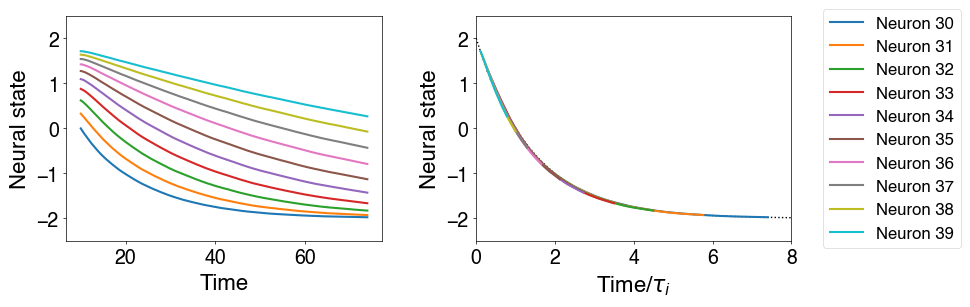

In [78]:
plt.figure(figsize=(10,3))
min_state,max_state = -2.5,2.5

t_max = 80

# plot state over time for particular neurons
plt.subplot(1,2,1)
neuron_indices = range(n_0,n_0+10)
analytical_times = np.linspace(0,t_max,1000)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    plt.plot(states[name],label=name,
             color='C{}'.format(neuron_index-n_0)) #color=str((neuron_index-n_0)/10))
leg = plt.legend(loc=(2.4,-0.03))
plt.xlabel('Time')
plt.ylabel('Neural state')
plt.axis(ymin=min_state,ymax=max_state)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.savefig('231018_firing_rate_vs_time.pdf')

# plot rate over time for particular neurons, rescaled in time
plt.subplot(1,2,2)
neuron_indices = range(n_0,n_0+10)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    times = states[name].index
    tau = t_0*np.exp((neuron_index-n_0)*delta_z)
    plt.plot(times/tau,states[name],label=name,
             color='C{}'.format(neuron_index-n_0)) #str((neuron_index-n_0)/10))
# also plot analytical result as dotted line
plt.plot(analytical_times/t_0,
         net.J*(2*desiredEdgeRates(n_0,analytical_times,n_0=n_0-fiddle_offset)-1),
         'k:',
         label=name,
         zorder=-10,
         lw=1,)
#leg = plt.legend()
plt.xlabel('Time/$\\tau_i$')
plt.ylabel('Neural state')
plt.axis(ymin=min_state,ymax=max_state,xmin=0,xmax=8)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.yscale('log')

plt.subplots_adjust(wspace=0.3,bottom=0.2,top=0.95,left=0.1,right=0.825)
#plt.savefig('240118_firing_rate_vs_time.pdf')

# old as of 2024/1/26

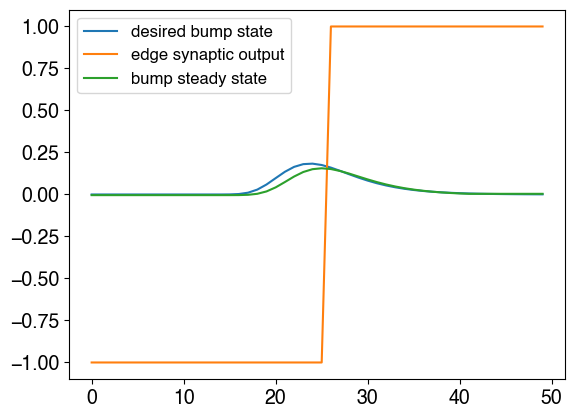

In [18]:
# 2024/1/26 design edge_bump_Jmat to give the desired bump given step function input
# TO DO: THIS LOOKS DECENT BY EYE---HOW CAN WE MAKE IT (NUMERICALLY) EXACT?
edge_state = net.J*(2*desiredEdgeRates(np.linspace(0,Npopulation),t_0,delta_z=delta_z,n_0=n_0)-1)
bump_state = net.J*desiredBumpRates(np.linspace(0,Npopulation),t_0,delta_z=delta_z,n_0=n_0)
bump_kernel = np.array([desiredBumpRates(30-n,1,n_0=14) for n in range(32)])
deriv_bump_kernel = bump_kernel[:-1] - bump_kernel[1:]
edge_bump_Jmat = delta_z**4*interaction_matrix_from_kernel(deriv_bump_kernel,Npopulation,normed=True)
edge_synaptic_out = net.nonlinearity(edge_state)
bump_steady_state = np.dot(edge_bump_Jmat,edge_synaptic_out)
plt.plot(bump_state,label='desired bump state')
plt.plot(edge_synaptic_out,label='edge synaptic output')
plt.plot(bump_steady_state,label='bump steady state')
plt.legend()